In [7]:
import xarray as xr
import ast
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.path import Path

In [3]:
with open("eddyCenterpoints_fullYear.txt",'r') as f:
        data = f.read()
        eddyLocation = ast.literal_eval(data)


eddy_df = xr.open_dataset('/nird/projects/NS9608K/MSc_EK/Data/Eddies_fullYear.nc')['EddyDetection']
eddy_area = eddy_df.where(eddy_df != 4, other=np.nan)

In [4]:
display(eddy_area)

<xarray.DataArray 'EddyDetection' (time: 365, Y: 231, X: 510)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * X        (X) float64 -21.98 -21.93 -21.87 -21.82 ... 1.822 1.879 1.936 1.994
  * Y        (Y) float64 70.01 70.03 70.04 70.06 ... 74.89 74.92 74.95 74.99
    XC       (Y, X) float64 -21.98 -21.93 -21.87 -21.82 ... 1.879 1.936 1.994
    YC       (Y, X) float64 70.01 70.01 70.01 70.01 ... 74.99 74.99 74.99 74.99
  * time     (time) datetime64[ns] 2017-09-01 2017-09-02 ... 2018-08-31
    Z        float64 -1.0
Attributes:
    long_name:      free-surface_r-anomaly
    units:          m
    standard_name:  sea_surface_height_above_geoid
    _coordinates:   XC YC iter

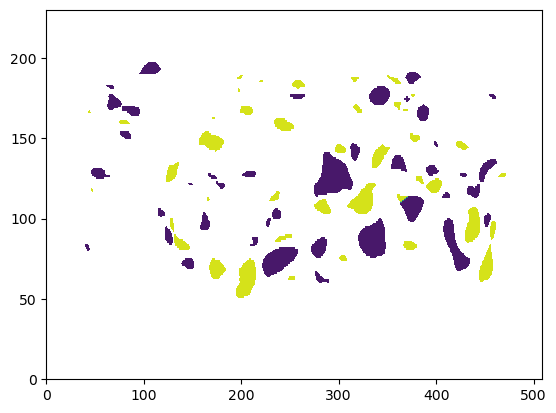

In [6]:
plt.contourf(eddy_area[0])

In [44]:
eddy_time = xr.zeros_like(eddy_area).rename('EddyID')
ID_locMax = []
ID_locMin = []

ID_num = 0

def is_closed_contour(vertices, tol=1e-5):
                distance = np.linalg.norm(vertices[0] - vertices[-1])
                return distance < tol


# Process Contour Paths to Handle Jumps
def process_contour_path(vertices, jump_threshold=0.05):
    segments = []
    current_segment = [vertices[0]]
    
    for i in range(1, len(vertices)):
        if np.linalg.norm(vertices[i] - vertices[i-1]) > jump_threshold:
            segments.append(np.array(current_segment))
            current_segment = [vertices[i]]
        else:
            current_segment.append(vertices[i])
    
    if current_segment:
        segments.append(np.array(current_segment))
    
    return segments



for time in range(len(eddyLocation)):
    eddy_max = []
    for eddy in eddyLocation[time][0]:
        if time == 0:
            contour = plt.contourf(eddy_area.X,eddy_area.Y,eddy_area[time])
            plt.close()

            all_contour_points = []

            for collection in contour.collections:
                for path in collection.get_paths():
                    # Collect the vertices of the path
                    vertices = path.vertices
                    all_contour_points.append(vertices)

            processed_contour_segments = []
            for vertices in all_contour_points:
                segments = process_contour_path(vertices)
                processed_contour_segments.extend(segments)
            
            for vertices in processed_contour_segments:
                # Create a Path object from the vertices
                path_obj = Path(vertices)
                
                # Check if the contour segment is closed
                if is_closed_contour(vertices, tol=1e-5):  # Adjust the tolerance value as needed
                    # Check if the center point is inside the contour segment
                    region = Path(vertices)
                    if region.contains_point((eddy[1],eddy[0])):
                        eddy_max.append([ID_num,eddy])
                        ID_num += 1
                        break
        
        else:
            contour = plt.contourf(eddy_area.X,eddy_area.Y,eddy_area[time])
            plt.close()

            all_contour_points = []

            for collection in contour.collections:
                for path in collection.get_paths():
                    # Collect the vertices of the path
                    vertices = path.vertices
                    all_contour_points.append(vertices)

            processed_contour_segments = []
            for vertices in all_contour_points:
                segments = process_contour_path(vertices)
                processed_contour_segments.extend(segments)
            
            for vertices in processed_contour_segments:
                # Create a Path object from the vertices
                path_obj = Path(vertices)
                
                # Check if the contour segment is closed
                if is_closed_contour(vertices, tol=1e-5):  # Adjust the tolerance value as needed
                    # Check if the center point is inside the contour segment
                    region = Path(vertices)
                    if region.contains_point((eddy[1],eddy[0])):
                        points = [(X[1][1],X[1][0]) for X in ID_locMax[-1]]
                        if any(region.contains_point(point) for point in points):
                             for find_ID in ID_locMax[-1]:
                                  if region.contains_point((find_ID[1][1],find_ID[1][0])):
                                    ID = find_ID[0]
                                    eddy_max.append([ID,eddy])
                                    break
                            
                        else:
                            eddy_max.append([ID_num,eddy])
                            ID_num += 1
            
    ID_locMax.append(eddy_max)

/tmp/ipykernel_1727940/2362579964.py:40: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for collection in contour.collections:
/tmp/ipykernel_1727940/2362579964.py:70: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for collection in contour.collections:


Unexpected exception formatting exception. Falling back to standard exception
Error in callback <function _draw_all_if_interactive at 0x7f4b870bf060> (for post_execute), with arguments args (),kwargs {}:
Unexpected exception formatting exception. Falling back to standard exception
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/nird/home/ekv036/MSc_env/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code
  File "/tmp/ipykernel_1727940/2362579964.py", line 65, in <module>
  File "/nird/home/ekv036/MSc_env/lib/python3.11/site-packages/matplotlib/pyplot.py", line 3154, in contourf
  File "/nird/home/ekv036/MSc_env/lib/python3.11/site-packages/matplotlib/__init__.py", line 1473, in inner
  File "/nird/home/ekv036/MSc_env/lib/python3.11/site-packages/matplotlib/axes/_axes.py", line 6675, in contourf
  File "/nird/home/ekv036/MSc_env/lib/python3.11/site-packages/matplotlib/contour.py", line 813, in __init__
  File "/nird/home/ekv036/MSc_env/lib/python3.11/site-packages/matplotlib/contour.py", line 1470, in _process_args
  File "/nird/home/ekv036/MSc_env/lib/python3.11/site-packages/matplotlib/contour.py", line 1510, in _contour_args
  File "/nird/home/ekv036/MSc_env/lib/python3.11/site-packages/matplotlib/contour.py", line 1554, in _check

<Figure size 640x480 with 1 Axes>

In [ ]:
display(ID_locMax)

[[[0, [71.07944607, -9.051355615000006]],
  [1, [71.24183117499999, -14.804034194999986]],
  [2, [71.27832667499999, -10.910303474999994]],
  [3, [71.44451680499998, -8.921229190000004]],
  [4, [71.50065753999999, -6.552864020000002]],
  [5, [71.51945712999999, -11.818612484999994]],
  [6, [71.55718772499998, -15.796889765000007]],
  [7, [71.70992321499999, -14.047889654999986]],
  [8, [71.70992321499999, -11.299252189999992]],
  [9, [71.82647603499998, -16.11679916500001]],
  [10, [71.82647603499998, -10.867105779999994]],
  [11, [72.166987675, -13.343242894999996]],
  [12, [72.27030151, -8.443156064999997]],
  [13, [72.29115009, -13.73885856]],
  [14, [72.333038035, -12.035384914999995]],
  [15, [72.63380034999999, -7.393217254999996]],
  [16, [73.43008985499999, -9.91687383]]],
 [[0, [71.07944607, -8.964615635000005]],
  [1, [71.24183117499999, -14.804034194999986]],
  [3, [71.40730074999999, -8.921229190000004]],
  [4, [71.48190121999998, -6.508359640000002]],
  [6, [71.595096265, 

In [ ]:
Days = np.zeros(ID_locMax[-1][-1][0]+1)
for data in ID_locMax:
    for subData in data:
        Days[subData[0]] += 1

In [33]:
display(Days)

array([ 4.,  5.,  1.,  9., 18.,  1.,  4.,  3.,  1.,  1.,  8.,  1.,  3.,
        3., 21.,  2.,  1.,  1., 29.,  3.,  2.,  1.,  4.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1., 11.,  3.,  1.,  6., 15.,  1.,  1.,
        1.,  2.,  1.,  1.,  1.,  3.,  1.,  3.,  6.,  1., 11.,  2.,  1.,
        1.,  5.,  1.,  1.,  2.,  1.,  1.,  2.,  1.,  1.,  1.,  1.,  1.,
        1.,  3.,  1., 20.,  1.,  1., 13.,  1.,  1.,  1.,  3.,  1.,  1.,
        1.,  3.,  1.,  1.,  6.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  2.,  1.,
        1.,  3.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  2.,
        4.,  7.,  1., 16.,  1.,  1.,  1.,  1.,  1.,  1.,  4.,  1.,  6.,
        1.,  1.,  1.,  3.,  1.,  2.,  1.,  1.,  2.,  1.,  1.,  6.,  1.,
        1., 13.,  1.,  3.,  1.,  1.,  5.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  3.,  4.,  1.,
        1.,  1.,  1.,  2.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1

(1.0, 30.0)

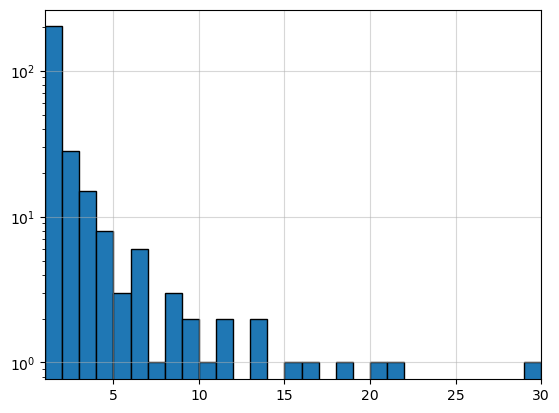

In [ ]:
plt.hist(Days,bins=29,range=[1,30],log=True,edgecolor='black')
plt.grid(alpha=0.5)
plt.xlim(1,30)
plt.xlabel('Days')
plt.ylabel('Frequency')
plt.title('Test tracking first month')